In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback, TqdmCallback
from deephyper.problem import HpProblem
from deephyper.search.hps import CBO
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from torch.nn import CrossEntropyLoss
from torchvision.ops import sigmoid_focal_loss
from tqdm import tqdm

from psd_gnn.dataset_v2 import PSD_Dataset
from psd_gnn.models.node_classifier import GNN
from psd_gnn.utils import eval_metrics

# %matplotlib notebook
%matplotlib

In [3]:
torch.manual_seed(0)
np.random.seed(0)
''' Load data '''
dataset = PSD_Dataset("../",
                        "1000genome",
                        node_level=True,
                        binary_labels=True)
data = dataset[0]
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
n_nodes = data.num_nodes

NUM_NODE_FEATURES = dataset.num_node_features
NUM_OUT_FEATURES = dataset.num_classes

In [31]:
def run(config):
    hidden_size_ = config['hidden_size']
    conv_blocks_ = config['conv_blocks']
    lr_ = config['lr']
    weight_decay_ = config['weight_decay']
    dropout_ = config['dropout']
    loss_func_ = config['loss_func']
    # alpha_ = config['alpha']
    # gamma_ = config['gamma']
    # reduction_ = config['reduction']

    model = GNN(NUM_NODE_FEATURES,
            hidden_size_,
            NUM_OUT_FEATURES,
            n_conv_blocks=conv_blocks_,
            dropout=dropout_).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=lr_,
                                weight_decay=weight_decay_)
    data = dataset[0]
    data = data.to(DEVICE)
    model.train()
    class_weight = 1 - data.y[data.train_mask].bincount() / data.y[data.train_mask].shape[0]
    for epoch in range(500):
        optimizer.zero_grad()
        y_hat = model(data.x, data.edge_index)
        if loss_func_ == "ce":
            train_loss = CrossEntropyLoss(weight=class_weight)(y_hat[data.train_mask], data.y[data.train_mask])
        # elif loss_func_ == "fl":
        #     train_loss = sigmoid_focal_loss(y_hat[data.train_mask],
        #                        torch.eye(2, device=DEVICE)[data.y[data.train_mask]],
        #                        alpha=alpha_,
        #                        gamma=gamma_,
        #                        reduction=reduction_)
        train_loss.backward()
        optimizer.step()
    model.eval()
    val_y_true = data.y[data.val_mask].detach().cpu().numpy()
    val_y_pred = y_hat[data.val_mask].argmax(dim=1).detach().cpu().numpy()
    val_acc = accuracy_score(val_y_true, val_y_pred)
    val_f1 = f1_score(val_y_true, val_y_pred)
    val_roc_auc = roc_auc_score(val_y_true, val_y_pred)

    return val_acc, val_roc_auc, val_f1

In [33]:
''' Setup HPS '''
problem = HpProblem()
problem.add_hyperparameter(['ce'], "loss_func", default_value="ce")
problem.add_hyperparameter([32, 64, 128, 256], "hidden_size", default_value=64)
problem.add_hyperparameter([1, 2, 3, 4], "conv_blocks", default_value=2)
problem.add_hyperparameter((0., 0.5, "uniform"), "dropout", default_value=0.5)
problem.add_hyperparameter((1e-5, 1e-2, "uniform"), "lr", default_value=1e-3)
problem.add_hyperparameter((0., 1e-3, "uniform"), "weight_decay", default_value=0.)
# problem.add_hyperparameter((0., 1., "uniform"), "alpha", default_value=0.25)
# problem.add_hyperparameter((1, 10), "gamma", default_value=2)
# problem.add_hyperparameter(['mean', 'sum'], "reduction", default_value="mean")
print(problem)

evaluator = Evaluator.create(run,
                                method="ray",
                                method_kwargs={
                                    "address": None,
                                    "num_gpus": 1,
                                    "num_gpus_per_task": 1,
                                    "num_workers": 10,
                                    "callbacks": [TqdmCallback()]})
print("Number of workers: ", evaluator.num_workers)
search = CBO(problem,
                evaluator,
                initial_points=[problem.default_configuration],
                moo_scalarization_strategy="Linear"
                )
results = search.search(100)
print(results)
# idx_best = (results.objective_0 + results.objective_1).argmax()


2023-01-11 14:02:08,138	WARNING worker.py:1851 -- Warning: The remote function __main__.run is very large (9 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Configuration space object:
  Hyperparameters:
    conv_blocks, Type: Ordinal, Sequence: {1, 2, 3, 4}, Default: 2
    dropout, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.5
    hidden_size, Type: Ordinal, Sequence: {32, 64, 128, 256}, Default: 64
    loss_func, Type: Categorical, Choices: {ce}, Default: ce
    lr, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001
    weight_decay, Type: UniformFloat, Range: [0.0, 0.001], Default: 0.0

Number of workers:  10


  0%|          | 0/100 [00:00<?, ?it/s]

(scheduler +2h11m37s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +2h15m7s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +2h21m48s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(scheduler +2h29m49s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors

In [45]:
results
# pickle.dump(results, open("hps_res_acc_f1_auc.pkl", "wb"))

In [24]:
results.iloc[1]

conv_blocks                 1
dropout                0.3784
hidden_size               128
loss_func                  ce
lr                   0.003653
weight_decay         0.000429
job_id                      2
objective_0          0.755008
objective_1          0.820164
objective_2          0.833388
timestamp_submit     0.066392
timestamp_gather    22.106877
Name: 1, dtype: object

In [30]:
top_10_idx = (results.objective_0 + results.objective_1+results.objective_2).sort_values(ascending=False).index[:10]

0.7939632545931758

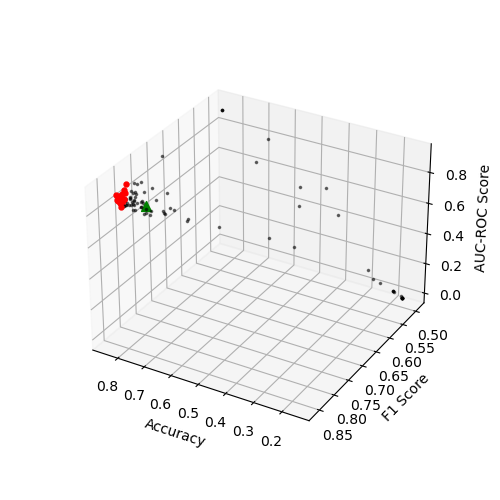

In [6]:
# plot the 3D scatter
# %matplotlib notebook
# from mpl_toolkits.mplot3d import axes3d
results = pickle.load(open("hps_res_acc_f1_auc.pkl", "rb"))
max_idx = (results.objective_0 + results.objective_1 + results.objective_2).argmax()
top_10_idx = (results.objective_0 + results.objective_1 + results.objective_2).sort_values(ascending=False).index[:20]
# markers = []
# colors = ['k'] * 100
# for k in top_10_idx:
#     colors[k] = 'r'
# colors[1] = "b"

# for i in range(100):
#     if i == max_idx:
#         colors.append("r")
#     else:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
# ax.scatter(results.objective_0,
#            results.objective_1,
#            results.objective_2,
#            c=colors,
#            marker="o")

for i in range(100):
    if i in top_10_idx:
        ax.scatter(results.iloc[i].objective_0,
                   results.iloc[i].objective_1,
                   results.iloc[i].objective_2,
                   c="r",
                   s=50,
                   marker=".")
    elif i == 1:
        ax.scatter(results.iloc[i].objective_0,
                   results.iloc[i].objective_1,
                   results.iloc[i].objective_2,
                   c="g",
                   s=50,
                   marker="^")
    else:
        ax.scatter(results.iloc[i].objective_0,
                   results.iloc[i].objective_1,
                   results.iloc[i].objective_2,
                   c="k",
                   s=10,
                   marker=".", alpha=0.5)
ax.set_xlabel("Accuracy")
ax.set_ylabel("F1 Score")
ax.set_zlabel("AUC-ROC Score")
ax.view_init(30, 120)
# plt.show()
# plt.savefig("../hps_results_acc_f1_roc.pdf", transparent=True)

# print(results.iloc[max_idx])


In [54]:
fv = -np.asarray(results.filter(regex=r"^objective_\d+$").values)



array([[0.79396325, 0.85264791, 0.86284427],
       [0.7550076 , 0.82016364, 0.83338813],
       [0.67371184, 0.49544542, 0.79608046],
       [0.800594  , 0.83031035, 0.86957307],
       [0.81806879, 0.85206824, 0.88168179],
       [0.84445365, 0.5       , 0.91566806],
       [0.15554635, 0.5       , 0.        ],
       [0.74982732, 0.79463648, 0.8312366 ],
       [0.15554635, 0.5       , 0.        ],
       [0.70534604, 0.80850967, 0.79061549],
       [0.69374223, 0.78696767, 0.78230558],
       [0.80853709, 0.84099068, 0.87504508],
       [0.70417185, 0.78933933, 0.79169301],
       [0.70175439, 0.80638306, 0.78752091],
       [0.57722061, 0.74749929, 0.66652138],
       [0.84445365, 0.5       , 0.91566806],
       [0.15554635, 0.5       , 0.        ],
       [0.64663628, 0.78642668, 0.73607099],
       [0.15554635, 0.5       , 0.        ],
       [0.79866004, 0.85796467, 0.8662169 ],
       [0.77068656, 0.84755997, 0.84424845],
       [0.80888244, 0.85170061, 0.87464323],
       [0.

Text(0, 0.5, 'Validation Accuracy')

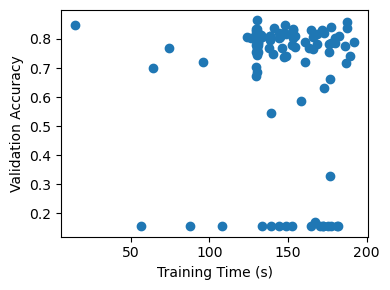

In [30]:
from deephyper.skopt.moo import pareto_front, hypervolume
fig = plt.figure(figsize=(4, 3), tight_layout=True)
plt.scatter(results.timestamp_gather - results.timestamp_submit, results.objective)
plt.xlabel("Training Time (s)")
plt.ylabel("Validation Accuracy")


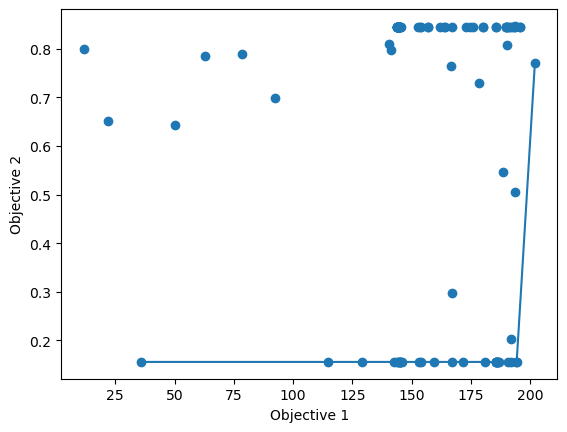

In [26]:
# pareto_front
def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
    # print(sorted_list)
    '''Plotting process'''
    plt.scatter(Xs,Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    plt.plot(pf_X, pf_Y, )
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.show()
fig = plt.figure()
plot_pareto_frontier(results.timestamp_gather - results.timestamp_submit, results.objective)


Text(0, 0.5, 'ROC-AUC Score')

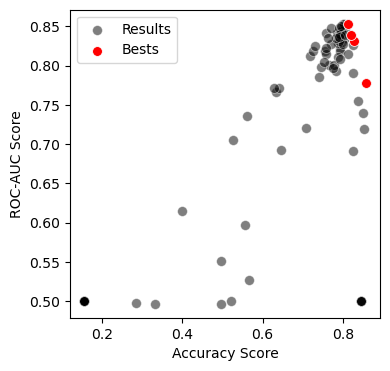

In [43]:
from deephyper.skopt.moo import pareto_front, hypervolume
fig = plt.figure(figsize=(4, 4))

fv = -np.asarray(results.filter(regex=r"^objective_\d+$").values)
pf = pareto_front(fv)
# plt.scatter(-pf[:, 0], -pf[:, 1], c='r', alpha=1, s=20, label="Pareto front")
sns.scatterplot(results, x="objective_0", y="objective_1", s=50, c="k", alpha=0.5, label="Results")
sns.scatterplot(x=-pf[:, 0], y=-pf[:, 1], c='r', alpha=1, s=50, label="Bests")
plt.xlabel("Accuracy Score")
plt.ylabel("ROC-AUC Score")

In [41]:
results.iloc[idx_best]

conv_blocks                  2
dropout               0.471748
hidden_size                 32
loss_func                   ce
lr                    0.004278
weight_decay           0.00046
job_id                      45
objective_0           0.813027
objective_1            0.85343
timestamp_submit    490.907416
timestamp_gather    586.956953
Name: 44, dtype: object